In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("./data/train.csv", parse_dates=['datetime'])
train_data.shape

(10886, 12)

In [3]:
test_data = pd.read_csv("./data/test.csv", parse_dates=['datetime'])
test_data.shape

(6493, 9)

In [4]:
# Feature Engineering

In [5]:
train_data['year'] = train_data['datetime'].dt.year
train_data['month'] = train_data['datetime'].dt.month
train_data['day']=train_data['datetime'].dt.day
train_data['hour'] = train_data['datetime'].dt.hour

train_data['dayofweek'] = train_data['datetime'].dt.dayofweek
train_data.shape

(10886, 17)

In [6]:
test_data['year'] = test_data['datetime'].dt.year
test_data['month'] = test_data['datetime'].dt.month
test_data['day']=test_data['datetime'].dt.day
test_data['hour'] = test_data['datetime'].dt.hour

test_data['dayofweek'] = test_data['datetime'].dt.dayofweek
test_data.shape

(6493, 14)

<AxesSubplot:xlabel='windspeed', ylabel='count'>

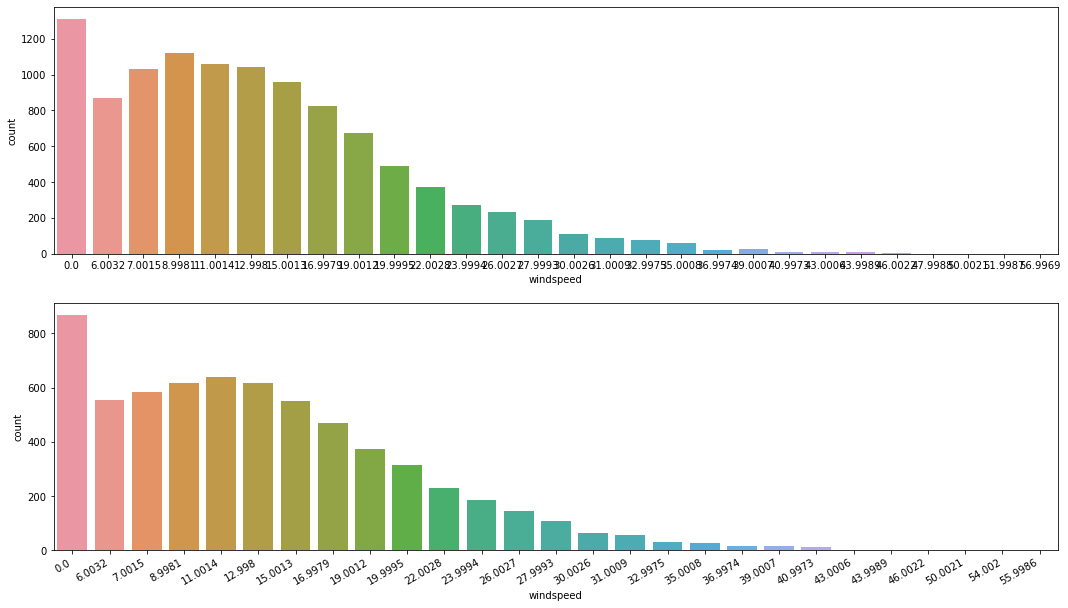

In [7]:
# windspeed

figure, axes = plt.subplots(nrows=2)
figure.set_size_inches(18, 10)

# plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
sns.countplot(data=train_data, x='windspeed',  ax=axes[0])
# sns.barplot(data=test_data, x='windspeed', y='count', ax=axes[0])

# plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
sns.countplot(data=test_data, x='windspeed',  ax=axes[1])

In [8]:
# two approaches to handle the 0 windspeed
# 1. fill the mean value into the 0 windspeed
# 2. make a sub regression modle to measure the windspeed 

In [9]:
# Approach 1
# train_data.loc[train_data.windspeed==0, 'windspeed'] = train_data['windspeed'].mean()
# test_data.loc[test_data.windspeed==0, 'windspeed'] = train_data['windspeed'].mean()

In [10]:
# Approach 2

train_wind_0 = train_data.loc[train_data['windspeed'] == 0]
train_wind_not0 = train_data.loc[train_data['windspeed']!=0]

print(train_wind_0.shape)
print(train_wind_not0.shape)


(1313, 17)
(9573, 17)


In [13]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    data_wind_0 = data.loc[data.windspeed ==0 ]
    data_wind_not0 = data.loc[data.windspeed != 0]
    
    wCol_for_prediction = ['season','weather', 'humidity', 'month', 'temp', 'year']
    
    data_wind_not0['windspeed'] = data_wind_not0['windspeed'].astype('str')
    
    rfModel = RandomForestClassifier()
    rfModel.fit(data_wind_not0[wCol_for_prediction], data_wind_not0['windspeed'])
    
    wind_predicted_value = rfModel.predict(X=data_wind_0[wCol_for_prediction])
    
    prediction_values = data_wind_0
#     prediction_values_not0 = data_wind_not0
    
    prediction_values['windspeed'] = wind_predicted_value
    
    data = data_wind_not0.append(prediction_values)
    data["windspeed"] = data["windspeed"].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

def predict_windspeed_for_test(train_data, test_data):
    test_data_wind_0 = test_data.loc[test_data.windspeed == 0]
    test_data_wind_not0 = test_data.loc[test_data.windspeed != 0]
    data_wind_not0 = train_data.loc[train_data.windspeed != 0]
    
    wCol_for_prediction = ['season','weather', 'humidity', 'month', 'temp', 'year']
    
    data_wind_not0['windspeed'] = data_wind_not0['windspeed'].astype('str')
    
    rfModel = RandomForestClassifier()
    rfModel.fit(data_wind_not0[wCol_for_prediction], data_wind_not0['windspeed'])
    
    print(test_data_wind_0.shape)
    wind_predicted_value = rfModel.predict(X=test_data_wind_0[wCol_for_prediction])
    
    print(wind_predicted_value.shape)
    prediction_values = test_data_wind_0
#     prediction_values_not0 = data_wind_not0
    
    prediction_values['windspeed'] = wind_predicted_value
    
    data = test_data_wind_not0.append(prediction_values)
    
    data["windspeed"] = data["windspeed"].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data


(867, 14)
(867,)


<AxesSubplot:xlabel='windspeed', ylabel='count'>

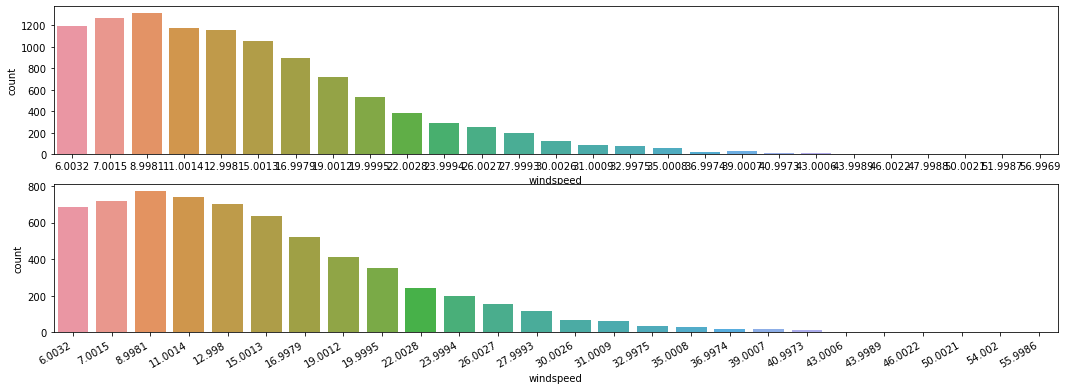

In [14]:
train = predict_windspeed(train_data)
test = predict_windspeed_for_test(train_data, test_data)

figure, ((ax1), (ax2)) = plt.subplots(nrows=2)
figure.set_size_inches(18,6)

# plt.sca(ax1)
plt.xticks(rotation=30, ha="right")
sns.countplot(data=train, x='windspeed', ax=ax1)

# plt.sca(ax1)
plt.xticks(rotation=30, ha="right")
sns.countplot(data=test, x='windspeed', ax=ax2)

In [15]:
test.shape

(6493, 14)

In [16]:
# Feature Selection

In [17]:
# set categorical variables their types as 'categorical'

In [18]:
categorical_vars = ["season","workingday", "weather", "dayofweek", "month","year","hour"]

for var in categorical_vars:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')



In [19]:
feature_names = ["season", "weather", "temp", "humidity", "windspeed", "year", "month", "hour", "dayofweek", "holiday"]

In [20]:
X_train = train[feature_names]
X_test = test[feature_names]

y_train = train['count']


In [21]:
# Evaluation

In [22]:
#RMSLE
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference_square = (log_predict - log_actual)**2
    mean_difference = difference_square.mean()
    
    score = np.sqrt(mean_difference)
    
    return score



In [23]:
rmsle_score = make_scorer(rmsle)

In [24]:
rmsle_score

make_scorer(rmsle)

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [33]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state =0)

In [34]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_score)

score = score.mean()

print("Score = {0}".format(score))

CPU times: user 8.64 s, sys: 19.5 s, total: 28.1 s
Wall time: 39.6 s
Score = 0.32519915779815556


In [28]:
# Train

model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=0)

In [29]:
predictions = model.predict(X_test)


<AxesSubplot:ylabel='Density'>

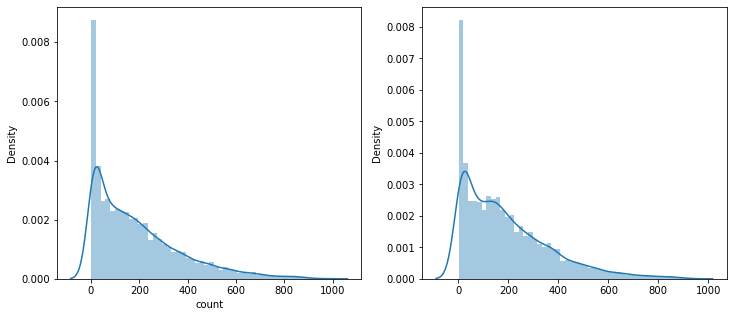

In [30]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,5)

sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(predictions, ax=ax2, bins=50)

In [31]:
# create submission file

submission = pd.read_csv("./data/sampleSubmission.csv")

print(submission.shape)
print(predictions.shape)
# submission['count'] = predictions

(6493, 2)
(6493,)


In [32]:
submission.to_csv('./data/Score_{0:0.5f}_submission.csv'.format(score), index= False)